<a href="https://colab.research.google.com/github/audrb1999/CS149_assignment/blob/main/05.ZeRO_Offload_Democratizing_Billion_Scale_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

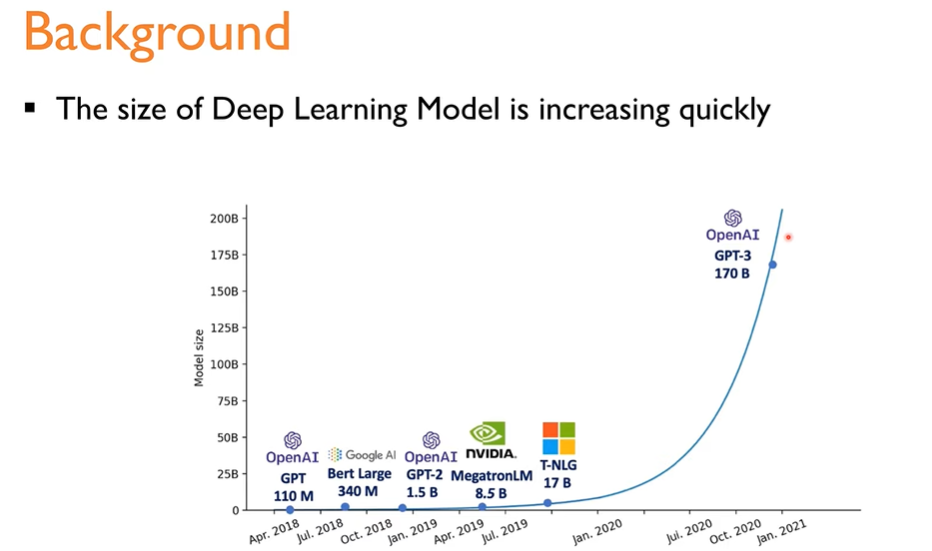

모델의 크기가 점점 증가함
- 모델 크기가 gpu 메모리 총합보다 큰 경우 학습이 불가능함

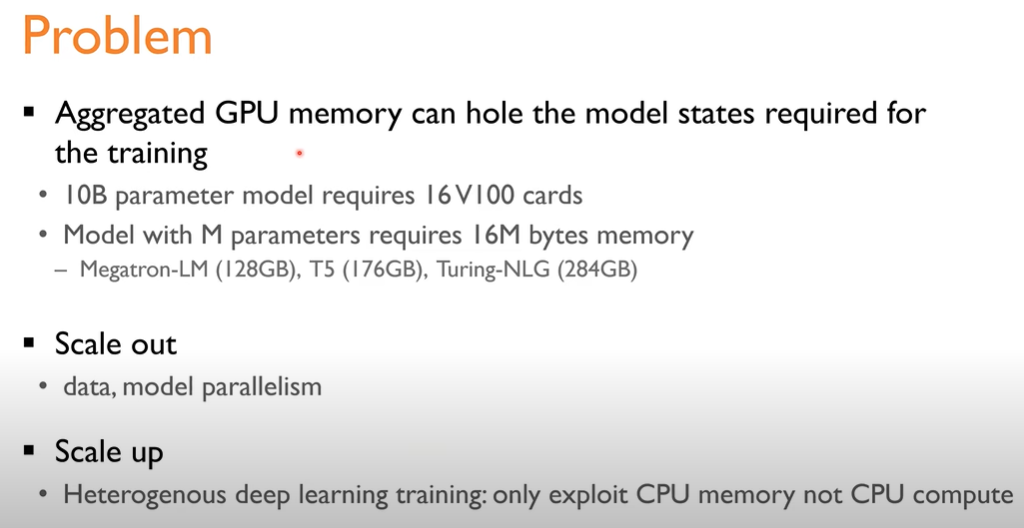

이러한 문제를 해결하는 방법으로는 스케일 아웃과 스케일 업이 존재



스케일 아웃은 데이터, 모델 페럴리즘 같은 방법을 사용

스케일 업: CPU를 계산하는데 사용하지 않고 메모리만 사용하는 방식

이 논문에서는 스케일 아웃과 스케일 업 방법의 문제를 해결하는 방법을 설명

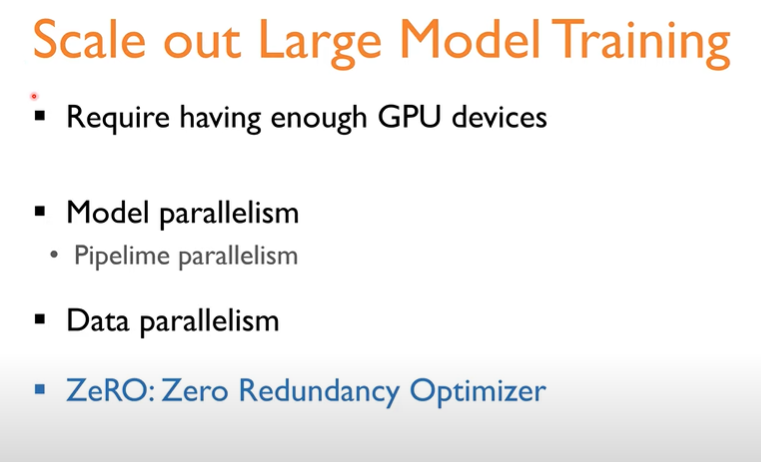

스케일 아웃하는 법

- 모델 사이즈가 커짐에 따라 gpu가 많이 필요함

그렇기 때문에 모델, 데이터, 파이프라인 병렬화가 많이 사용됨
- 이 논문에서는 기존에 나왔던 ZeRO optimizer를 토대로 확장성을 높임

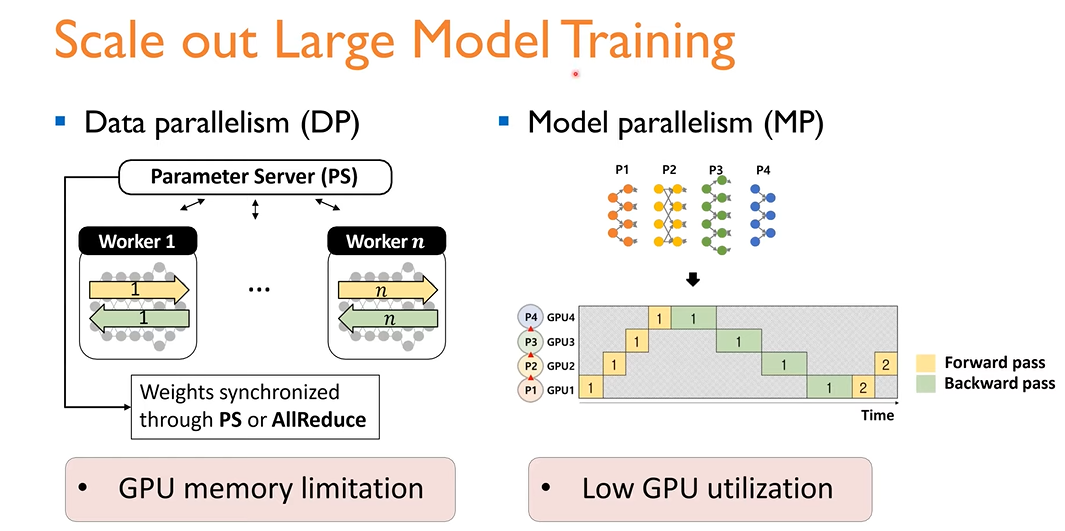

스케일 아웃에서

- DP = 데이터를 나누고 각 gpu에 모델을 복제해서 집어넣고 돌림
  - 각 복제된 모델을 gpu들이 들고 있어야 해서 gpu 메모리가 많이 사용됨
  - MP보다는 더 많이 사용됨

- MP = gpu 메모리 사용량을 극복하는 방법으로 모델을 partition으로 쪼개서 gpu에 각각 할당
  - gpu 사용량이 낮음
  - 이 문제를 파이프라인으로 해결했지만 사용하기 위해서는 모델 수정이 필요하고 사용하기가 어렵다는 단점이 존재

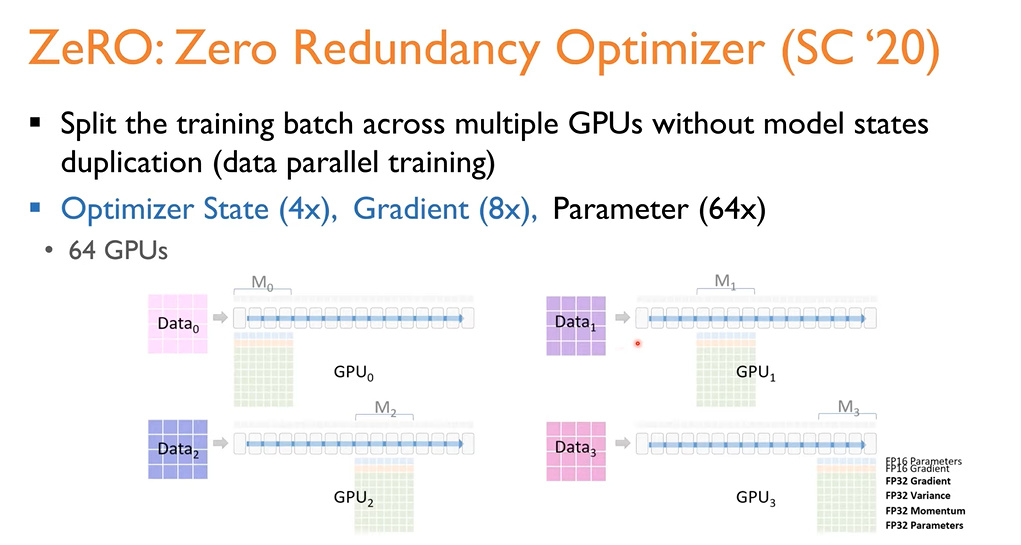

이 논문을 기반으로 zero offload에서 노드 간 확장성을 키움

- 데이터 페러럴과 비슷하게 데이터는 쪼개어 gpu들이 나눠서 학습
- 여기에서 각 gpu가 모델을 전부 가지는게 아니라 모델을 나눠서 가짐

모델같은 경우는 크게 옵티마니저, 그래디언트, 파라미터로 나눌 수 있는데
- 파라미터: 추론할 때 사용
- 그래디언트: 파라미터를 학습할 때 사용
- 옵티마이저: 그래디언트를 통해서 파라미터를 업데이트 시킴

이 논문에서는 이렇게 3가지에 대해서 옵티마이저만 나눠서 저장할 때는 메모리를 4배 아낄 수 있고, 기울기까지 같이 나눠서 저장하면 8배, 파라미터까지 같이 나눠서 저장하면 64배까지 메모리를 아낄 수 있다고함


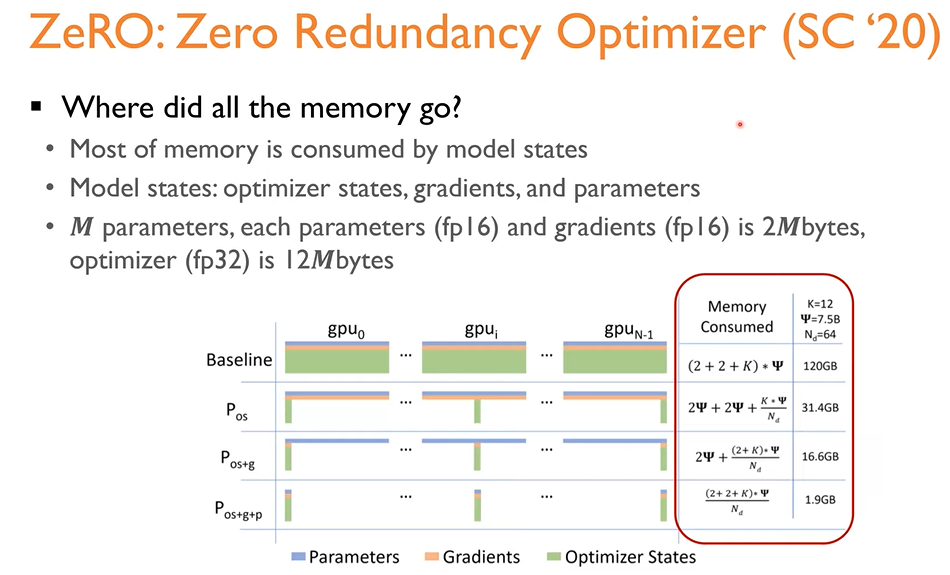

대부분의 메모리가 모델의 상태를 저장하는데 사용됨

- 모델의 상태: 옵티마이저, 그래디언트, 파라미터

n개의 파라미터가 존재할 때 파라미터와 그래디언트 fp16은 2n 바이트가 존재하고 옵티마이저 fp32는 12n 바이트를 차지

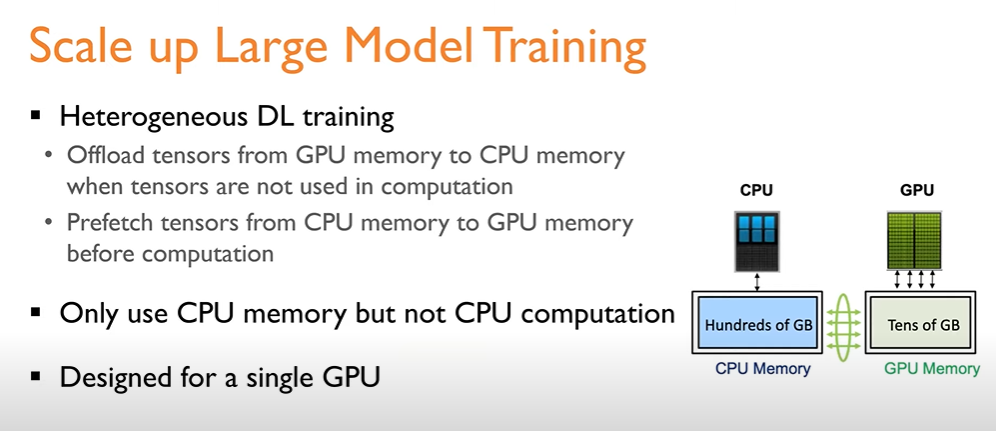

cpu 메모리에 오프로드하는 방식 기존은

오직 cpu 메모리만 사용한다는 점과 싱글 GPU에 대해서 설계되었다는 문제가 존재

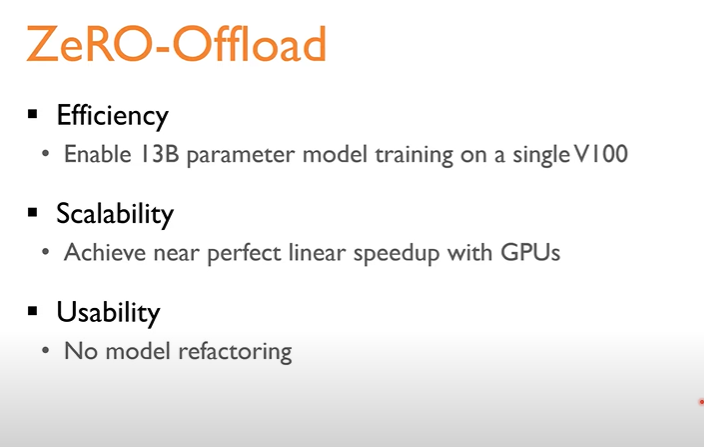

하나의 gpu에 13억 파라미터 모델이 올라갈 수 있고 여러 gpu를 사용할 시 선형적으로 속도 증가, 따로 모델 수정할 필요 없게

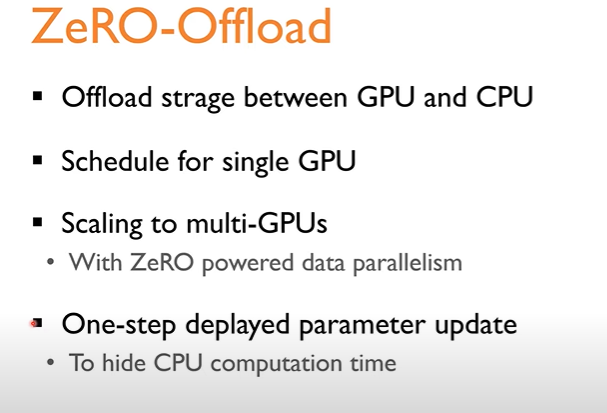

성능향상 제안 방법

1. gpu와 cpu 에게 offload를 하여서 gpu 성능 이점을 얻음
2. gpu를 사용할 때 스캐쥴을 하여 cpu의 커뮤니케이션 오버헤드를 숨김
3. 여러 개의 gpu를 사용할 경우 zero 기반 데이터 페럴리즘을 통해 여러 gpu를 사용하더라도 확장성이 좋게 만듬
- cpu의 computatuib time 때문에 생길 수 있는 오버헤드를 줄이기 위해서 one-step deplayed parameter update를 진행

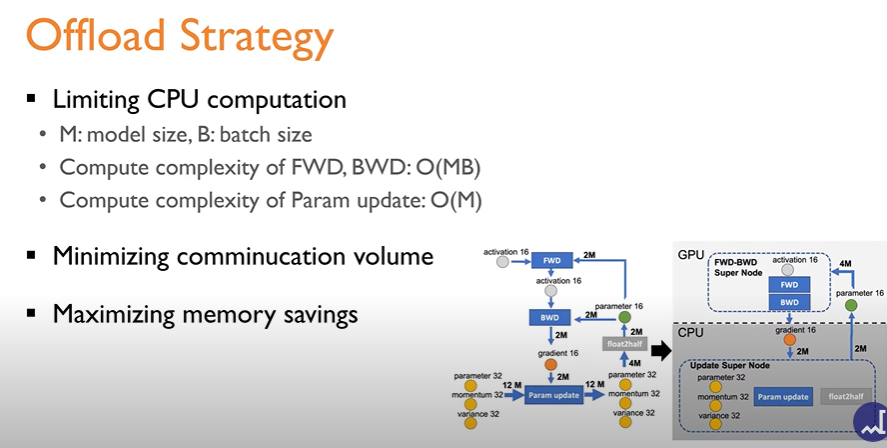

1. offload 전략에 대해서 알아보자

cpu의 computation 성능이 gpu의 computation 성능에 비해서 떨어지기 때문에 각각에 complexity를 계산해봄

오른쪽 아래에 데이터와 데이터 계산을 나타내주는 data flow graph가 존재

- 동그란 부분은 데이터를 나타내고
- 네모난 부분은 computing하는 과정을 나타냄 (계산 과정)
- 각각의 데이터가 어디서 어떻게 이동하는 데이터 flow 그래프를 그리고 이것을 각각 gpu와 cpu에 어떻게 할당을 할지에 대해서 고민함


____

gpu 컴퓨팅 성능에 따ㅏ라서 forward와 backward의 complexity는 O(MB) 의 복잡도를 가짐
- M = 모델 사이즈, B= 배치 사이즈

파라미터를 업데이트할 때는 O(M), 이때 complexivuty가 떨어지기 때문에 이 부분을 cpu에게 할당

그리고 comminuniation volume을 최소화 하기 위해서 GPU에서 파라미터들을 16 floating point로 사용을하고 CPU에서는 32fp로 사용
- cpu에서 반으로 나누고 그걸 gpu에게 보내주는 식으로 진행함 이걸 통해 communication volume을 최소화함

> fp를 낮춘다 = 양자화와 같은 원리 속도증가와 배치 사이즈 증가가 생김

https://byeongjo-kim.tistory.com/31

그 다음 메모리 세이빙을 최대화하기 위해서, gpu, cpu 중 fp16(기울기 등)값들을 어디에 집어너야 최대한 메모리를 절약할 수 있는지

- 그리고 컴퓨팅 성능에서 위에 방식에 따른 병목이 존재하지 않는 식으로 최적화를 진행

##  블로그 내용 요약

이진수로 표현하지 못하는 수들이 존재 142.3 같이

이때 컴퓨터가 근사값을 저장함

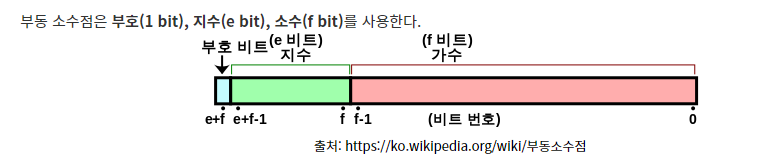

다음과 같이 부호, 정수 비트, 소수 비트 형태로 저장

이제 FP16과 FP32의 차이를 알아보자

- FP32의 경우 8bits 지수부와 23bits 가수부로 존재, 하지만 딥러닝의 경우 모든 자리의 지수부와 가수부가 필요한 겨우가 거의 없다.

- 그래서 대부분의 기울기와 가중치는 16bits로 표현될 수 있다. 그렇지 않은 gradient(매우 작은 애)인 경우 단순히 scaling up으로 이를 해결할 있다고 nvidia에서 분석함

- 따라서 FP16을 사용하여 5bits 지수부, 10bits 가수부로 줄일 수 있다. 정확도는 유지되면서 계산 효율성을 가지게 된다.

- 즉 이렇게 용량을 줄이니 커뮤니케이션 볼륨(통신량)이 줄어드는 것 같다.

> 의문 그러면 cpu에서도 16비트를 쓰면 좋지 않았을까?

## 다시 본론

2번 방법은

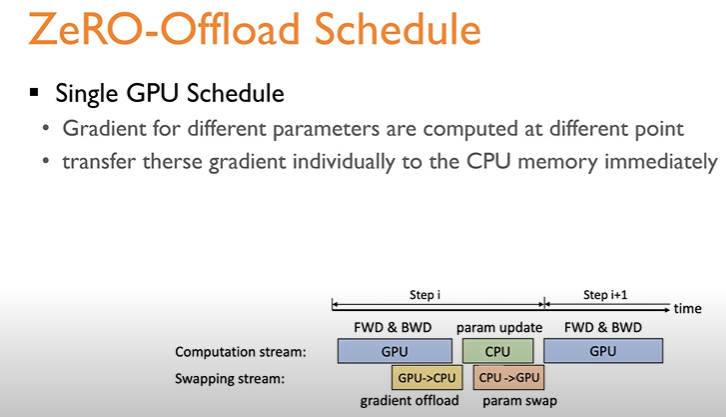


2번째 방법은 제로 오프로드 스케줄이란 방식

- 하나의 싱글 gpu를 사용할 경우 스케쥴을 하는 방법을 통해서 커뮤니케이션 오버헤드를 줄임

- Gradient를 나눠서 보내게 되면 GPU에서 모든 gradient를 전부 다 저장하지 않아도 되어서 GPU의 메모리 사용량을 줄일 수 있고 순전파와 오버랩핑(겹치게) 하여서 레이어 연산과정 및 파라미터 업데이트 과정에서 데이터를 보내는 과정을 겹쳐서 숨김

- 커뮤니케이션을 오버랩핑해서 커뮤니케이션 오버헤드를 줄임



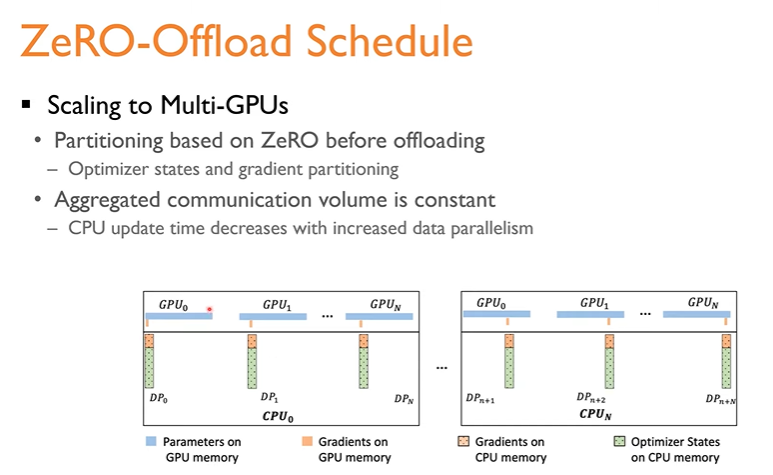

gpu가 옵티마이저와 그래디언트 두 부분만 각각 gpu가 가지고 있는 방식으로  zero를 사용함

그래디언트와 옵티마이저를 팔티션하고(나누고) 그 다음에 cpu에게 그래디언트와 옵티마이저를 오프로드하게 됨

- cpu에서는 파라미터 업데이트만 진행

- gpu에서는 실제로 학습에 해당하는 부분을 진행하여 gpu 메모리를 더 사용할 수 있고 cpu메모리와 cpu computing을 다 사용(파라미터 업데이트 과정에서) cpu와 gpu전부 활용

- 이에 따라서 gpu를 여러 개로 늘려도 메모리상 gpu 메모리가 사용된ㄴ 부분은 적고 cpu가 가지고 있는 부분이 많기 때문에 gpu에 따른 확장성이 좋아짐

- 커뮤니케이션 볼륨 부분에서 그래디언트와 옵티마이저 부분이 아무리 늘어난다고 하더라도 이것을 나눠서 가지고 있을거기 때문에 커뮤니케이션 볼륨이 일정함(통신량이 일정함, 동일한 크기로 가지고 있으니) gpu가 많아지더라도 cpu 업데이트 타임이 감소함

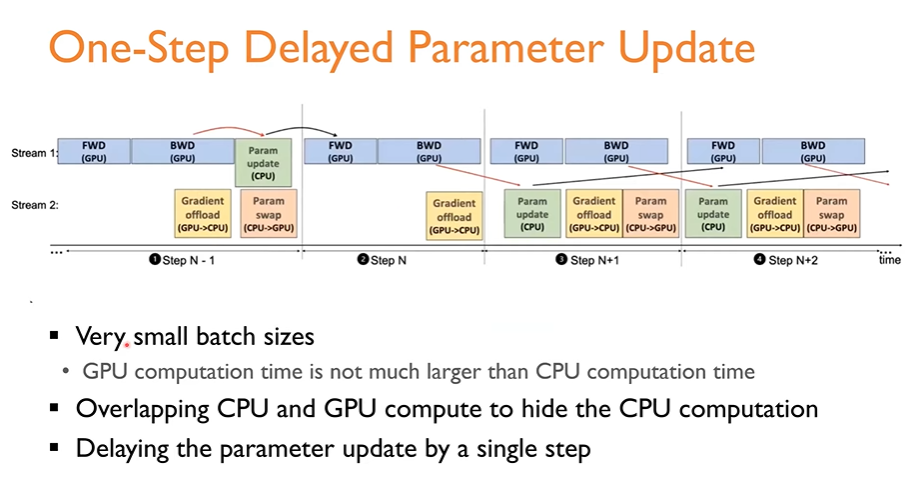

cpu computation 시간이 존재하는데 cpu 컴퓨팅 속도가 느려서 gpu에 컴퓨팅 속도가 늦어짐  

- 그걸 방지하고자 gpu와 cpu의 컴퓨팅 시간을 같이 오버랩핑함

처음에만 파라미터 업데이트 부분이 존재하고 다음부터는 gpu연산 시간에 숨겨져 있음(pramam updeate 부분)

> 이 방식으로 cpu의 계산 시간이 느려져서 발생하는 문제를 해결

- 이렇게 진행하면 파라미터 업데이트가 제때 진행되어서 최신 파라미터 정보를 쓰는 것이 아니기 때문에 정확도가 떨어짐 스케일네스 문제가 발생하지 않나?
  - 실험을 통해서는 별다른 정확도 하락이 발생하지 않았다고함, 속도는 증가함


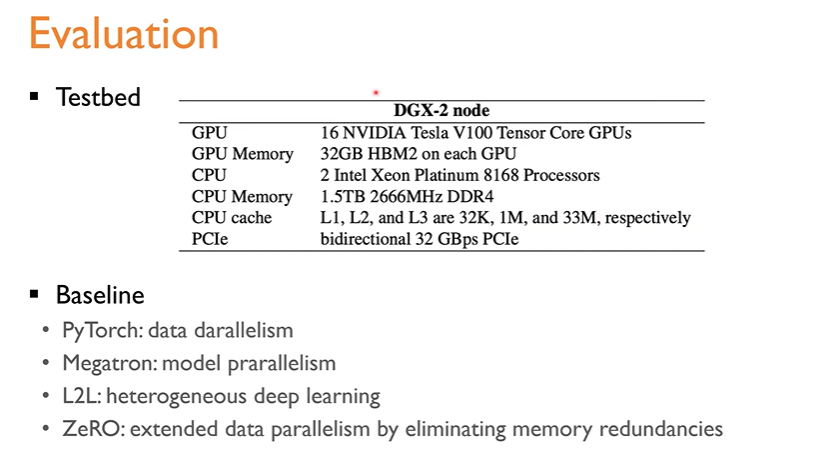

DGX-2 node라는 서버를 통해서 진행

- 베이스 라인은 파이토치 DP, MP, 본 논문에서는 cpu의 컴퓨팅 성능을 활용했지만 메모리만 사용한 방식과 비교

- 오프로드를 사용하지 않고 각각의 모델을 나눠서 gpu에 저장한 예전 zero 방식과 비교

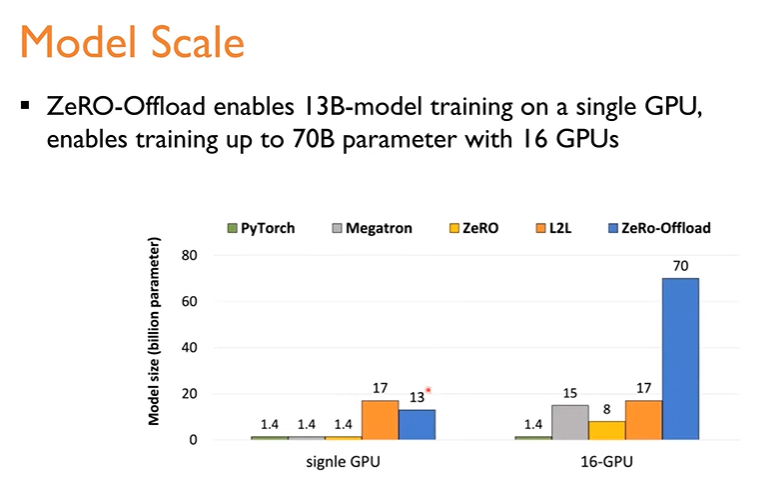

모델 스케일 부분을 살펴보면

- 모델 확장 = 같은 성능의 gpu에서 더 큰 모델을 담을  수 있다는 것

오퍼로드 방식이 싱글 gpu를 사용할 경우 13억개 모델까지 학습시킬 수 있었고

16개의 gpu를 사용할 경우에는 70B 모델을 학습시킬 수 있었다.

> 기존 데이터 페러럴 방식으로는 13B모델을 16개의 gpu가 있어야 학습이 가능 여기서는 cpu 메모리를 같이 사용하여서 gpu 메모리가 부족하더라도 큰 모델 학습이 가능

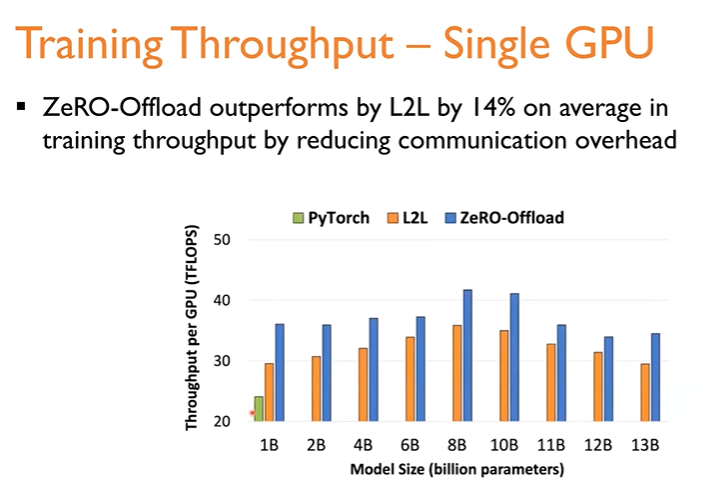

하나의 gpu를 사용했을 때 zero offload의 gpu당 Throguput 성능

- 가장 큰 이유는 하나의 gpu를 사용하여 커뮤니케이션 오버헤드를 줄여서, cpu gpu 통신하지만 커뮤니케이션 양을줄임(fp16으로) 이 방법과 스케쥴링하는 기법을 통해서 즐앋,ㅁ

-

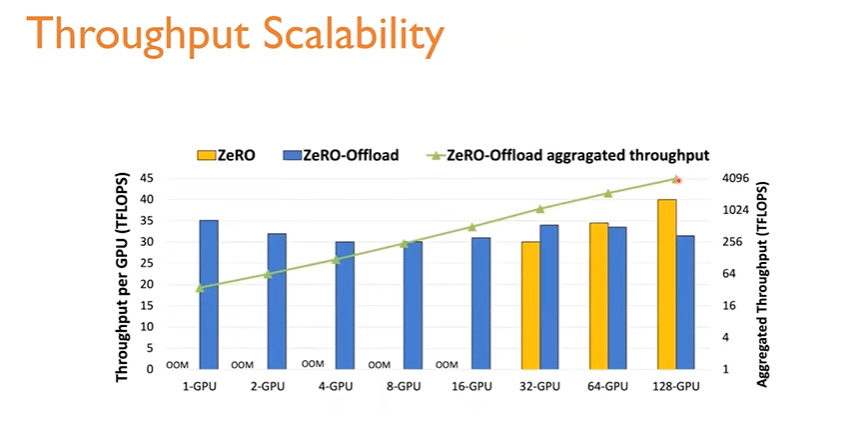

scalability throughput을 살펴보면

오퍼로드를 사용하지 않은 zero와 비교를함

zero같은 경우 1~16개의 gpu부분을 보면 out of memory로 인해서 학습을 할 수 없었음

- 그래서 주황그래프가 32gpu부터 나옴, zero는 cpu의 메모리를 사용하지 않기 때문에 gpu에 모델이 전부 다 저장이 안되서 생기는 문제

zero offload는 gpu 가 늘어남에 따라서 리니어한 쓰로풋을 보여줌

- 제로 오프로드가 32개 이후로는 성능이 떨어짐
- 이 이유는 32개까지는 gpu메모리 사용량을 cpu에게 오프로드하여서 한번에 학습시키는 데이터를 좀 더 많이 가져올 수 있어서 성능이 좋음
- 이게 무슨 의미일까?

128개까지 확장시킨 경우네는 제로가 메모리가 부족하지 않아서 성능이 더 좋음

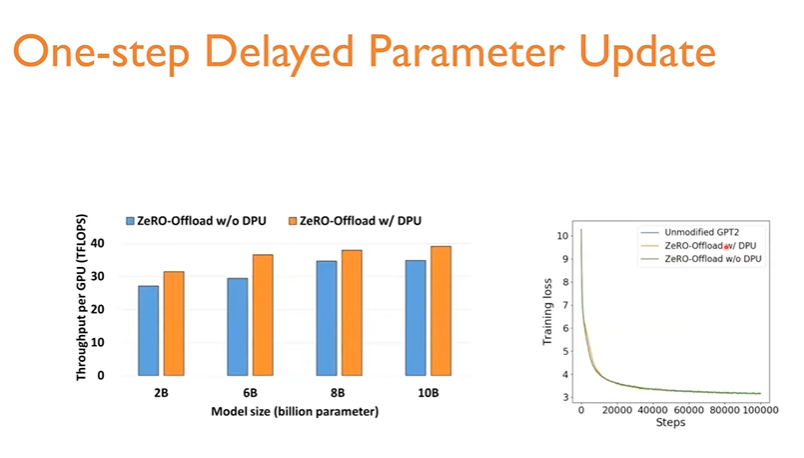

오래된 파라미터를 가지고 학습을 한 방법을 사용해을 때와 사용하지 않았을 때

한 단계 지연된 매개변수 업데이트 성능을 측정해보면 기법을 사용했을 때(주황)와 사용하지 않았을 때(파랑)

쓰로풋 같은 경우 10퍼센트 향상 차이가 남

Throughput per gpu(gpu 당 처리량 = 즉 처리량은 증가함, 시간 지연이 없으니까 하지만 정확도는 떨어짐)

근데 오른쪽 사진을 보면 스텝마다 정확도가 그리 크게 떨어지지 않고 유사하게 나옴

- 내 생각에는 이게 스케일이 커서 잘 안보이지만 적은 step에서는 유의미한 차이가 나올 것 같다, 계속 진행하면 차이가 줄어들고

> cpu와 gpu의 컴퓨팅 시간을 오버래핑하여서 한 단계 전에 파라미터를 사용한 방식


근데 모델이 크니까 스탭이 커질수밖에 없긴하니 없는셈친듯

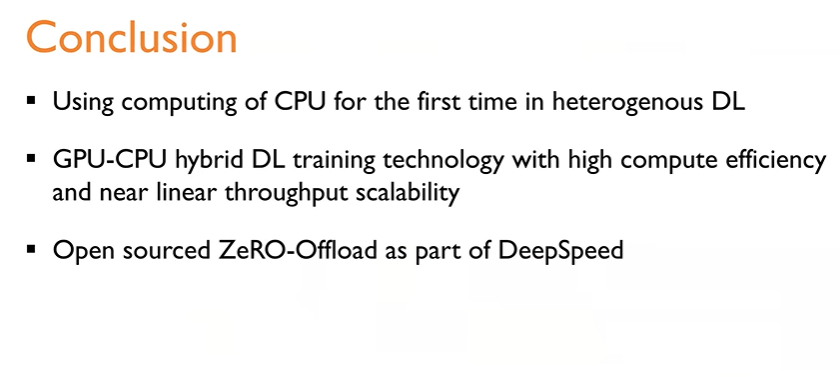

heterigenous에서 처음으로 cpu의 컴퓨팅 성능을 사용하여 오프로드함

- 기존에 cpu와 gpu를 같이 사용할 경우 하나의 gpu에 대해서만 연구가 많이 되어서  gpu 개수가 증가함에 따라 성능이 리니어하게 증가하지 않은 문제가 있었음

- 이 논문에서는 zero라는 논문에 기반을 두어서 여러개의 gpu를 사용하더라도 처리량의 확장성을 높일 수 있었다.

- 딥스피드의 오픈소스가 zero offload

## ZeRO inginity

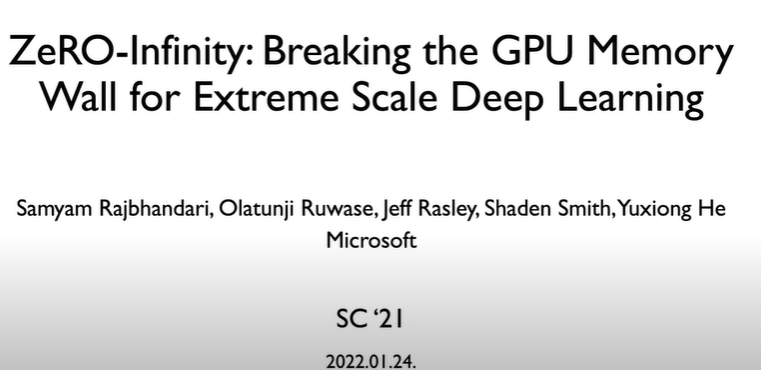

이 논문은 학습시 nvm을 사용하여서 gpu memory wall을 돌파

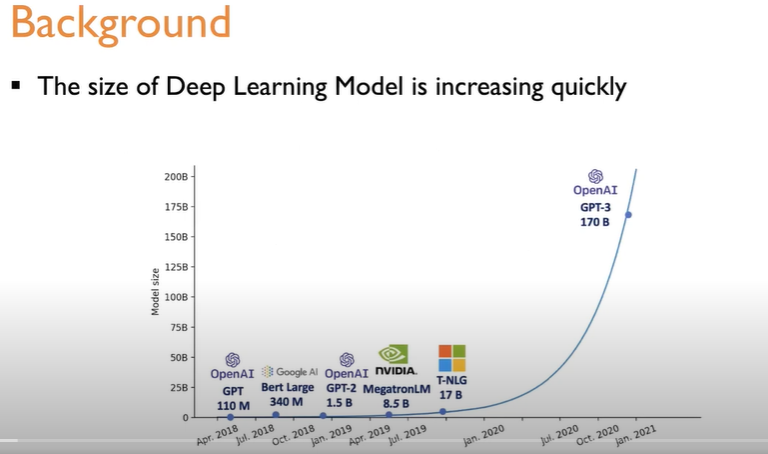

최근에 자연어 모델이 점점 커짐

170B 파라미터를 가짐, 한 개의 파라미터가 대략 20MB를 가짐

- 이렇게 커지는 원인? 모델이 커질 수록 성능 증가!



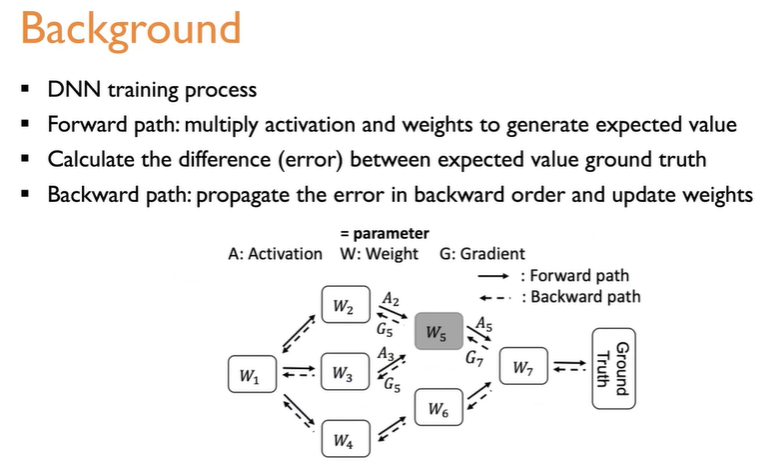

딥러닝 학습 과정

1. forward pass
2. calculate the difference(손실함수 구하고)
3. 역전파

forward pass를 통해서 얻어진 값을 activation이라고 함
이렇게 다음 activation을 계산하는 방식으로 이루어짐 마지막 레이어까지 fw가 진행되면 마지막에 ground truth와 비교를 하고 손실을 구한다음 그게 마지막 레이어의 인풋으로 들어가면서 bw가 시작됨

이 과정에서 gradient를 새로 계산을하고 맨 마지막에 bw가 끝나면 이 기울기를 가지고 파라미터를 업데이트함

dnn 학습 과정


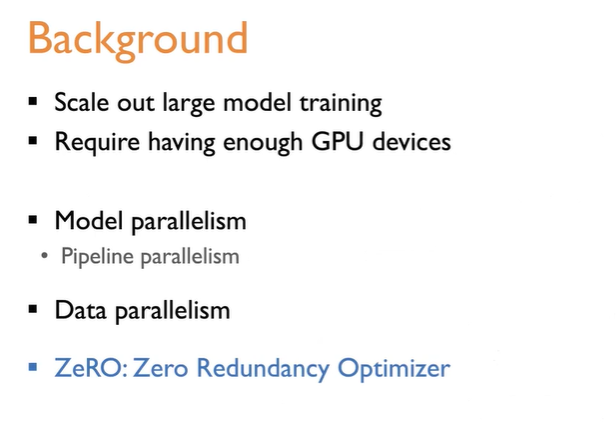

모델이 증가하면서 메모리가 부족해짐

- 이 문제를 해결하고자 나온 기준 방법들

본 논문은 zero optimizer의 후속 논문

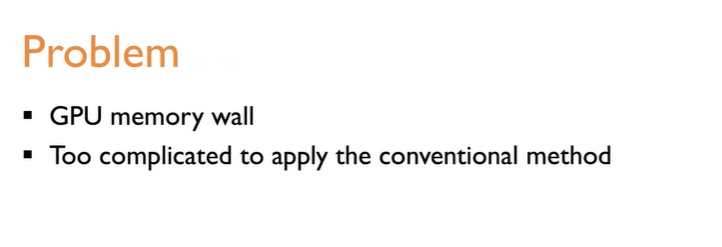

gpu 메모리 한계에 도달했고 DP, MP 같은 방법은 적용시키기가 어려움

마이크로소프트에서 제안한 제로 논ㅁㄴ은

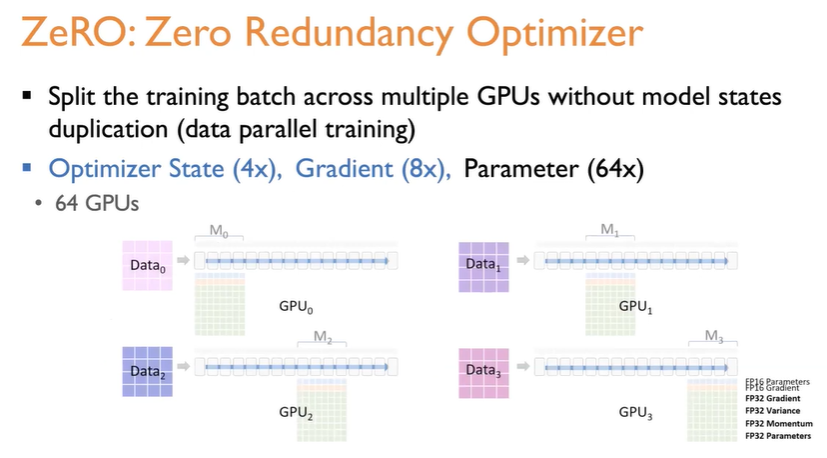


DP와 유사하게 동작하면서 모델을 잘라서 각 gpu에 전달 (MP와도 유사)

- MP와 DP를 같이사용하는 형태

데이터를 4분할해서 진행

파라미터 옵티마이저 스테이트 그라디언트를 gpu에 나눠서 넣음

- 데이터 학습이 진행되면서 필요한 모델 부분을 다른 gpu에 있는 걸 가져옴

3개 모두 나눌 경우 64배 효율이 좋아짐

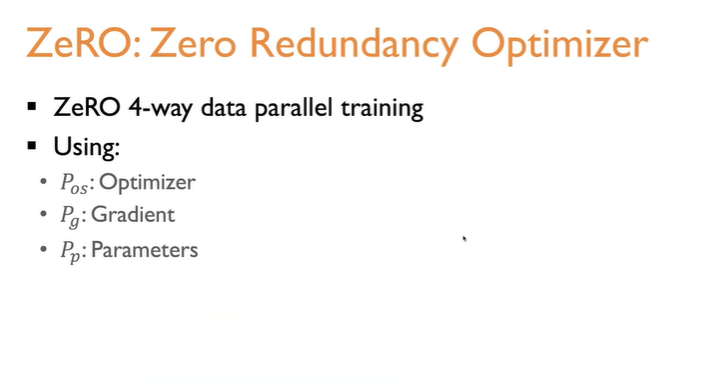

제로의 동작을 봐보자

데이터를 4개로 나눌 것이다.

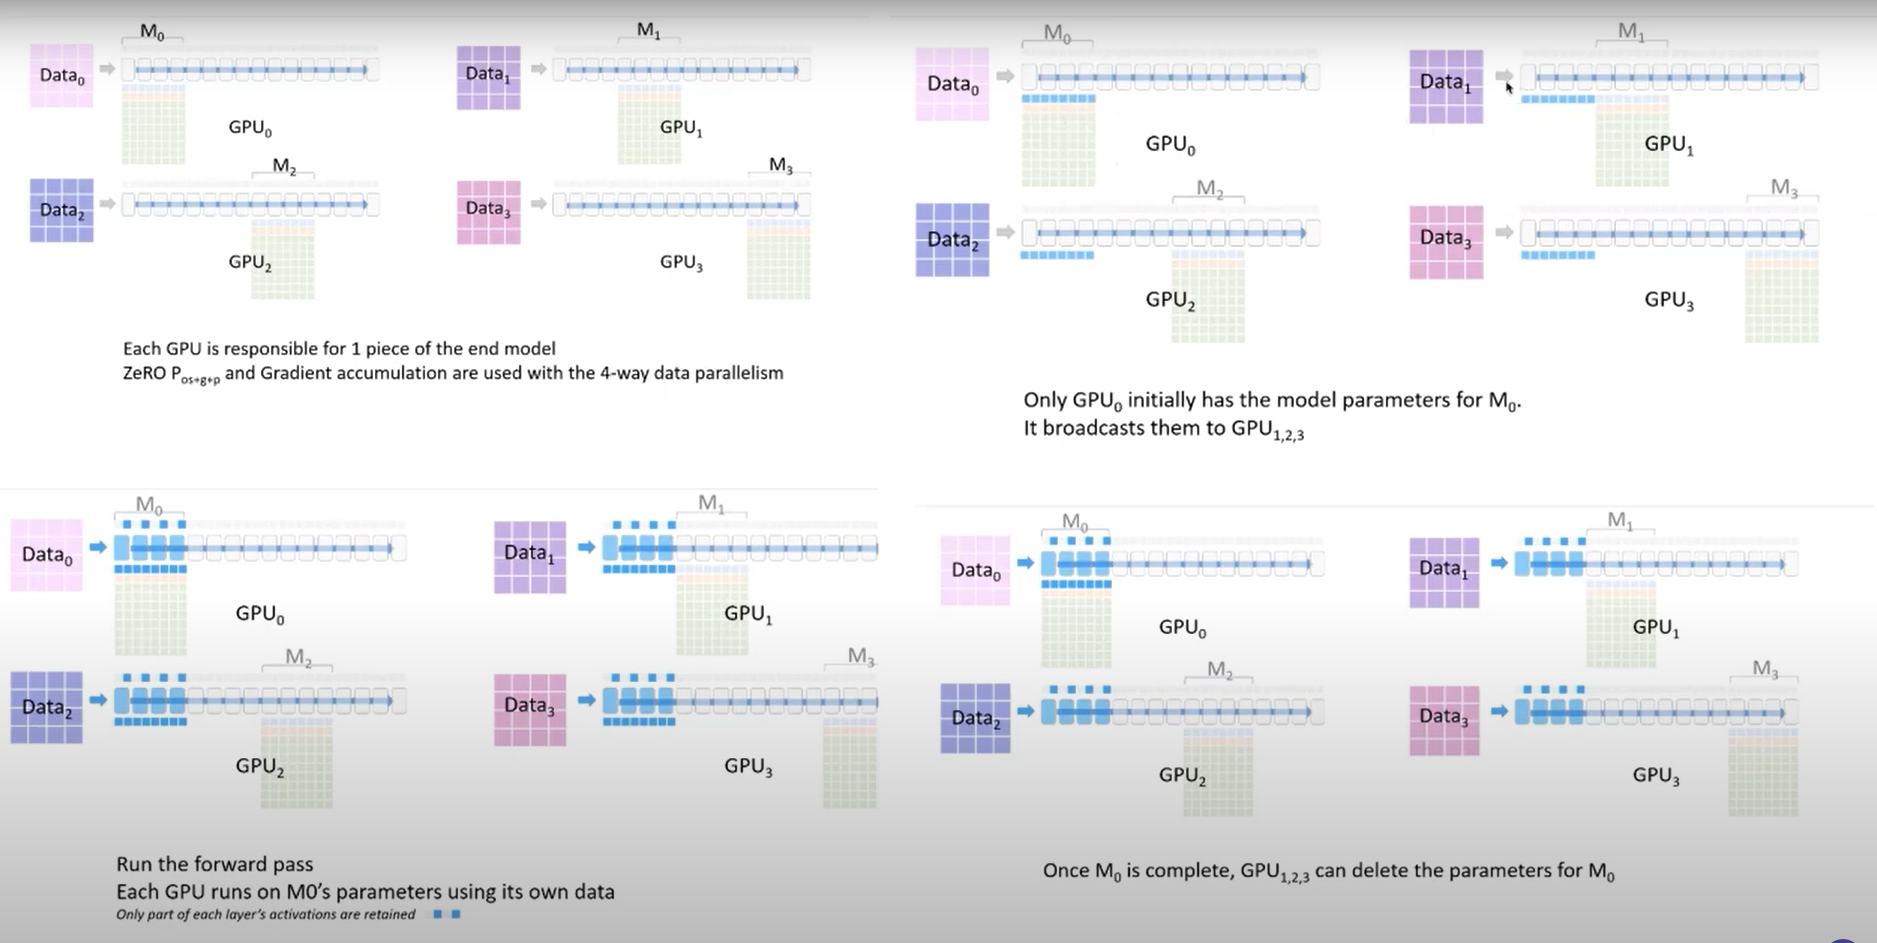

1. gpu들이 모델을 나눠서 가짐, 데이터를 4개로 나눔

2. 1번째 forward pass를 진행할 때 모든 gpu가 gpu0에 있는 파라미터를 가져와서 데이터 배치에 대해서 추론하고 반납함

3. 추론해서 나온 활성화 값을 버퍼에다 저장함

4. forward pass가 끝나면 가져온 파라미터들을 다 삭제함



```
# 코드로 형식 지정됨
```

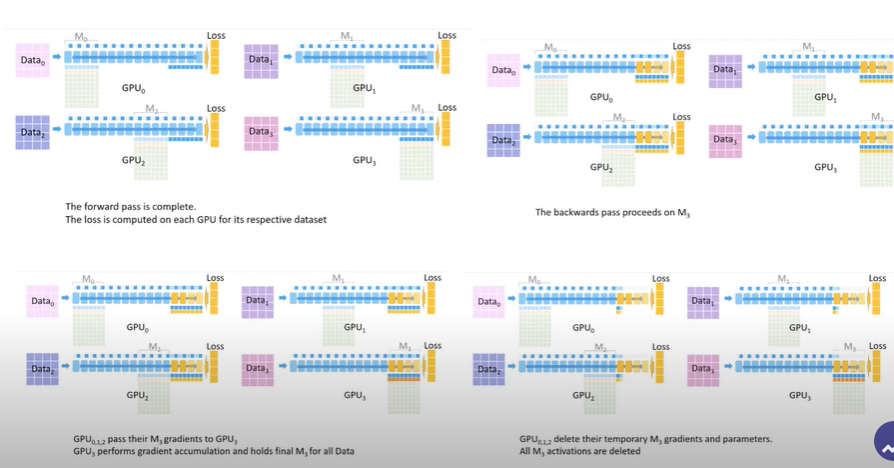

m3에 기울기값을 몰아준다는데 뭔 솔?

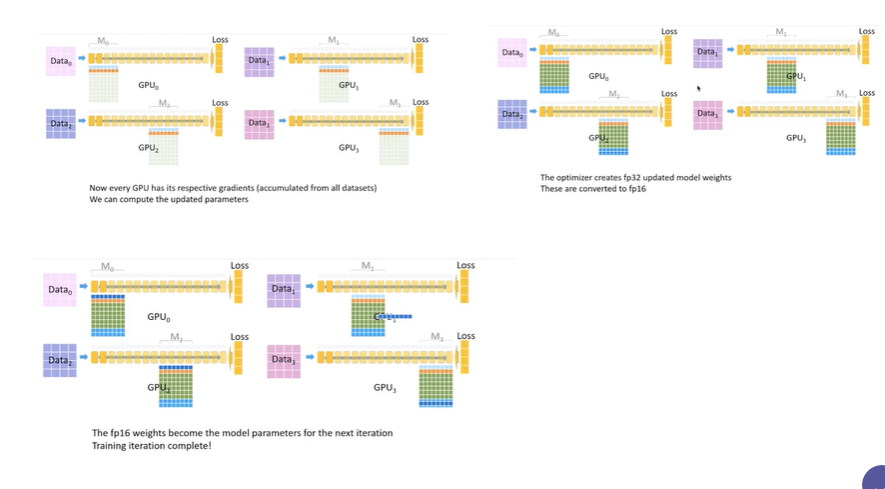

 맨 마지막에는 기울기 값만 gpu들에 남음

 그럼 이 기울기 값과 옵티마이저 값을 사용해서 파라미터 업데이트를 진행하면서 한번의 반복을 끝냄

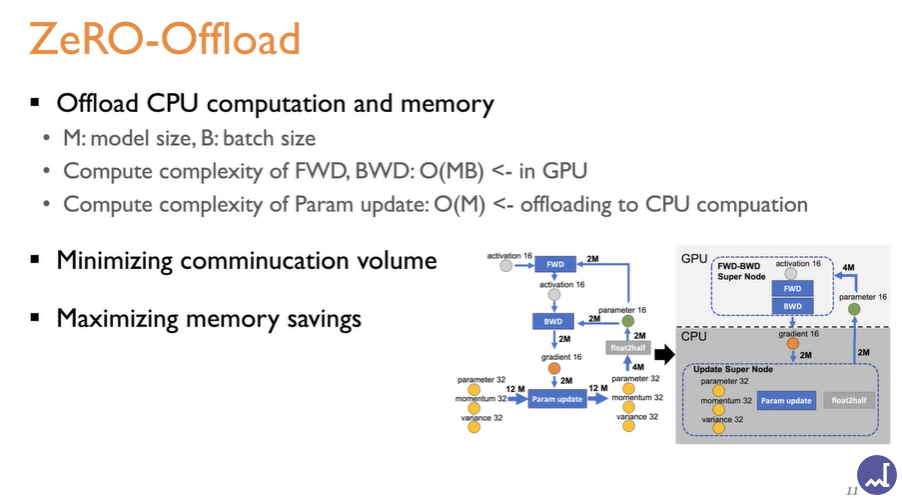

위의 방법은 모든 데이터가 gpu에 올라간 방법이고 이건 cpu에 올리는 방법

- cpu메모리와 ㄱ컴퓨팅을 사용하면 효과가 더 좋아지지 않을까? 에서 발생한 논문

- gpu메모리를 덜 사용함

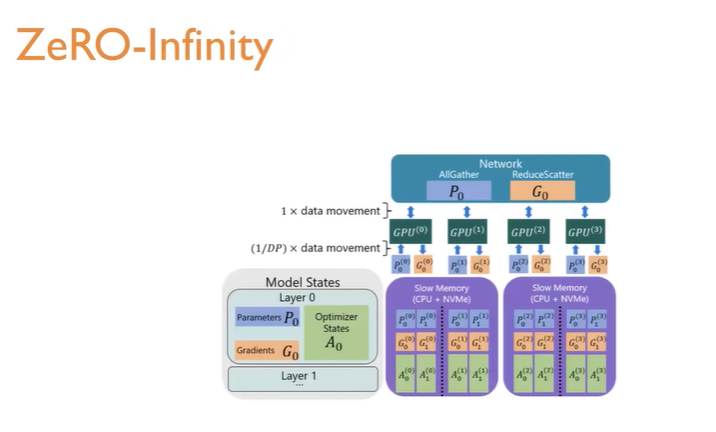

아키텍처는 다음과 같다.

핵심 포인트 nvme ssd를 사용해서 cpu 메모리 뿐만 아니라 데이터를 nvme ssd까지 내림

nvme ssd에서 cpu로 그리고 cpu에서 gpu로 데이터가 필요할 때 가져와서 학습하는 방법

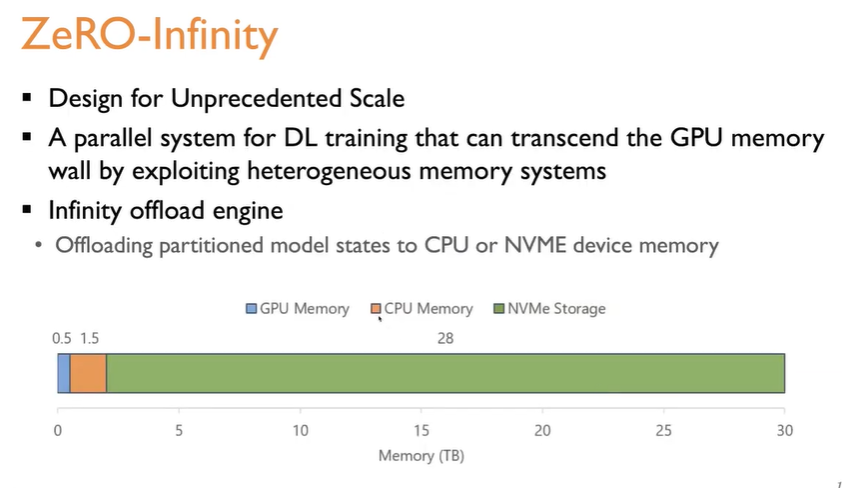

엄청나게 큰 모델을 학습하기 위해서 설꼐됨

- heterogeneous한 메모리 시스템을 사용해서 gpu 메모리 wall을 해결하기 위한 논문

nvme ssd를 메모리로 같이 사용함, cpu, gpu 메모리와 nvme의 스토리지 까지 같이 사용함

- 그때그때 내가 필요한 데이터만 로딩해서 사용

이걸 하기위해서 고려한 것들

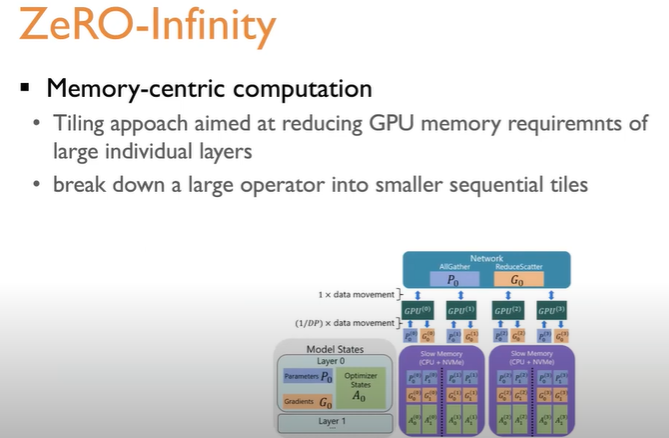

memory-centric compautation

- 레이어 0의 파라미터가 존재한다면 gpu하나가 통째론 관리했는데 여기서는 하나의 레이어의 파라미터도 여러 프로세서가 나눠서 보관(그래디언트와 옵티마이저도)

- 레이어 단위로 쪼개는게 아님

memory-centric하게 compautation할 수 있게 함

- 그 다음 큰 오퍼레이터를 작은 여러 개의 오퍼레이터로 나눠 해당 연산을 할 수 있게 만듬

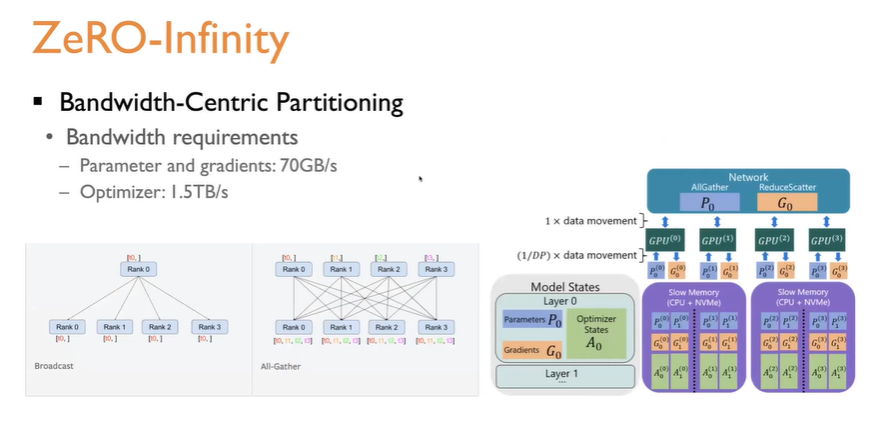

한 레이어를 통째로 가지고 있다면 학습할 때 필요한 gpu하나에게 모든 레이어가 브로드 캐스트를 받음(1:n)

이것보다 각각 나눠져서 각각 gpu들을 모아서 진행하면(n:n으로 커뮤니케이션을 진행)

bandwidth를 더 잘 활용할 수 있다

어느정도 bandwidth가 requirements한지 알아본결과

- 기울기와 파라미터는 70gb/s 면 문제가 없다.
- 옵티마이저는 1.5tb/s로 가져올 수 있느면 문제 없음
- 수식을 통해서 구한 값들 실험을 통해서 구한 것이 아님


이 두 방법 모두 커뮤니케이션 량이 차이가 없기 때문에 여러개의 파티션으로 나눠서 n:n으로 가져오는게 bandwidth 차원에서 유리하다

gpu가 해당 데이터로 연산을 하기 전에 hook을 넣어ㅓ ssd나 호스에 있는 데이터를 가져옴

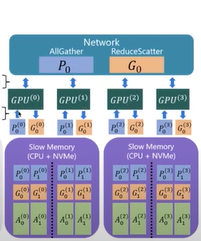

gpu에 파라미터들이 나눠져서 들어감
- 작게 나눠서 계산하는 것을 통해서 성능을 높임

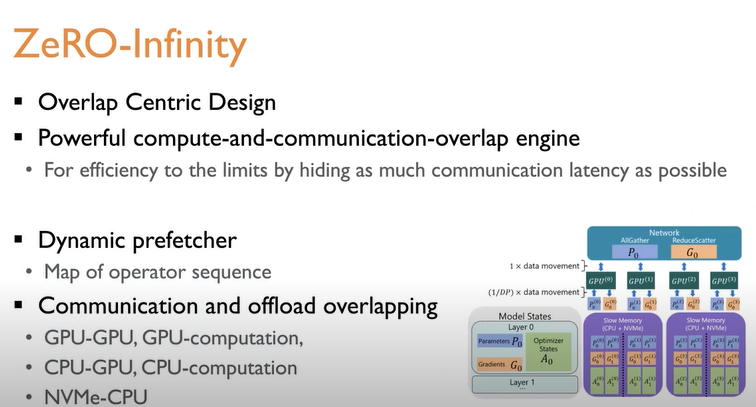

gpu로 데이터를 가져올 때 transfer 타임이 중요하기 때문에

- 계산과 커뮤니케이션을 오버랩하여 시간을 단축
- 여러 파티션으로 나눠서 gpu에 넣고 필요할 때 서로 공유하는 방법으로 성능을 높였지만 싱글 노드에서는 bandwith가 병목이 될 수 잇음

- 그걸 해결하기 위해서 overalab centric desigh을 활용한다.
- 파라미터들을 미리미리 프리패치함
- 다음 파라미터들을 nvme에서 cpu를 미리미리 패치함
- 그 다음 cpu에서 gpu로 프리패치하면 됨

gpu-cpu간 커뮤니케이션은 gpu 계산에 오버랩하고

cpu-gpu간 커뮤니케이션은 cpu 연산에서 오버랩함

- data transfer time을 최대한 숨김

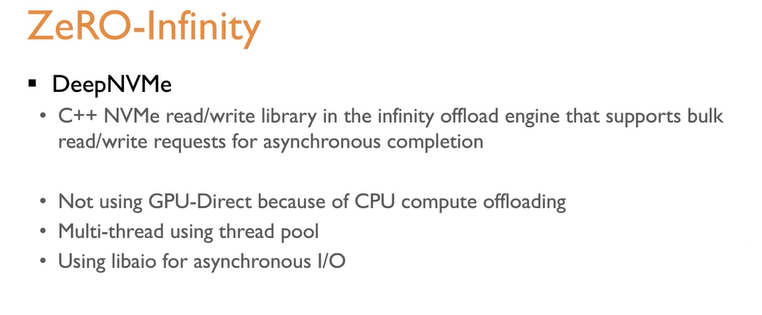

nvme을 사용할 때 deep nvme로 사용했다고 함

영어 다 읽어보기

- 쓰레드 풀을 사용해서 멀티 스레드 제공
- gpu에서 바로 cpu로 데이터를 전송하는 gpu 다이랙트 기술이 존재하는데 이걸 하지 않음

- cpu 계산을 offload하여서

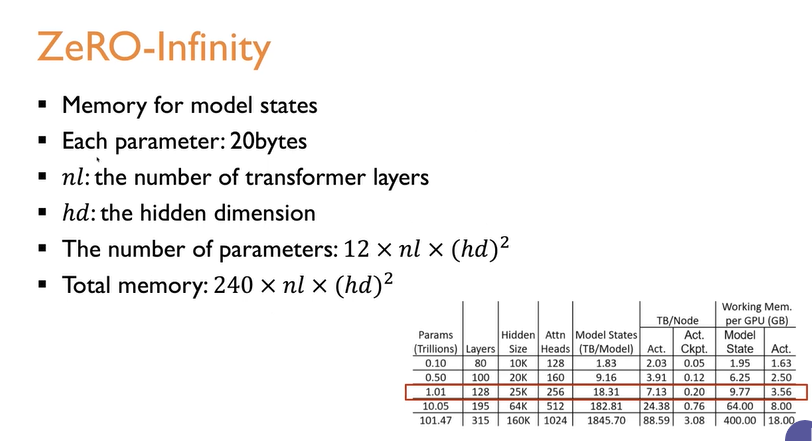

파라미터 량에 따른 모델 사이즈 계산 방법

- ㅇ학습이 충분히 되기 위해서는 30만번 반복되어야한다는데 이 경우 꽤 많은 nvme가 사용도;ㅁ

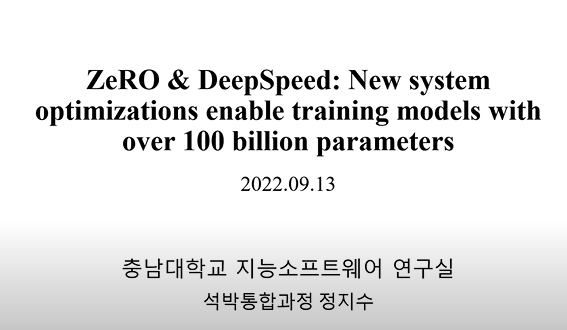

모델이 커짐에 따라 이런 모델도 훈련할 수 있는 방법을 생각핻냄

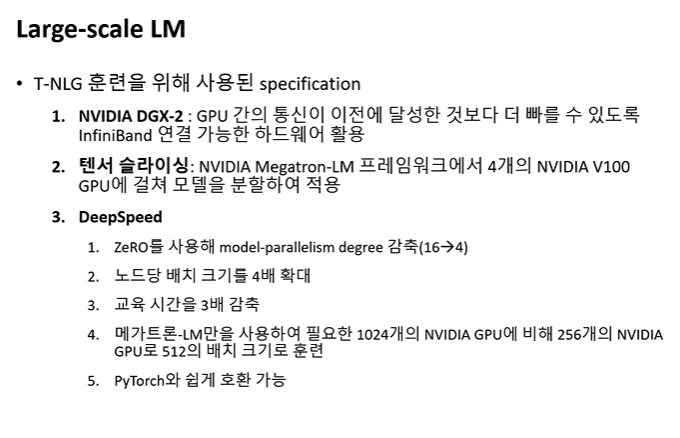

DGX2라는 infinband 단위로 연결이 가능한 하드웨어를 통해 통신을 진행

- 텐서 슬라이싱을 하여 nvdia v100 gpu에 모델을 분할하여 적용함


- Deep speed라는 라이브러리를 사용함
  - zero라는 라이브러리를 통해 모델 병렬 degree를 감축
  - 노드 당 배치 크기를 4배씩 확대
  - 교육시간을 3배 가량 단축

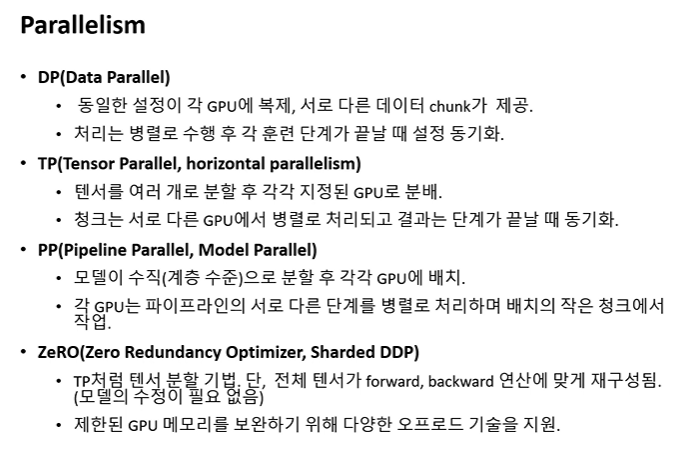

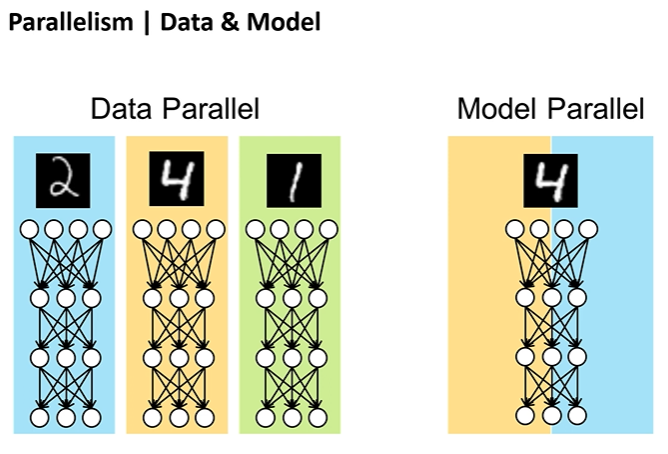

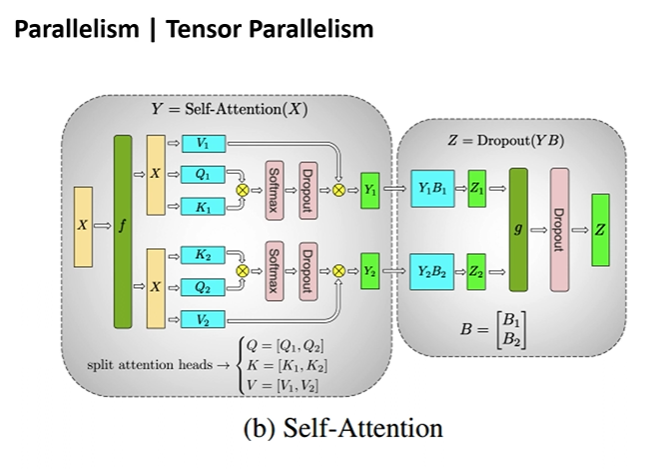

TP는 더 복잡함

- Attention에 대해서 텐서 페럴리즘을 적용할 때는 다음처럼 순서를 바꿔서 적용함

- self attention을 먼저 한 뒤 서로 병합을 해서 연산을 진행하는 것이 아니라 self attention을 2개의 gpu로 나눠서 진행을 함 그리고 여기에 대해서 드랍 아웃으로 concatnation을 진행

이렇게 3개의 페럴리즘을 사용한 것이 3D 병렬화

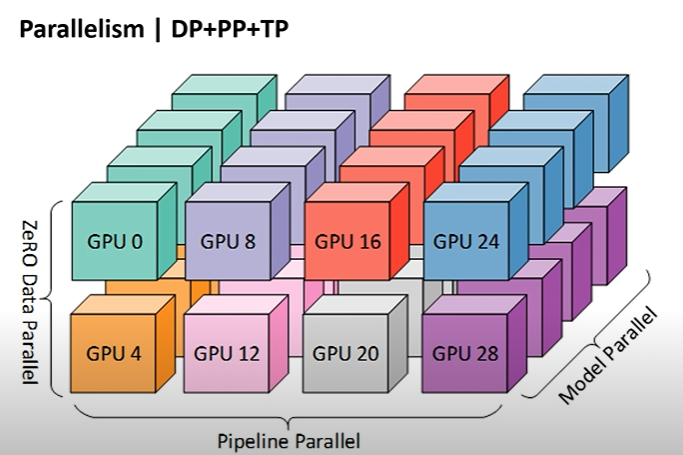

3개를 각각 쪼개어서 3차원으로 독립적으로 진행

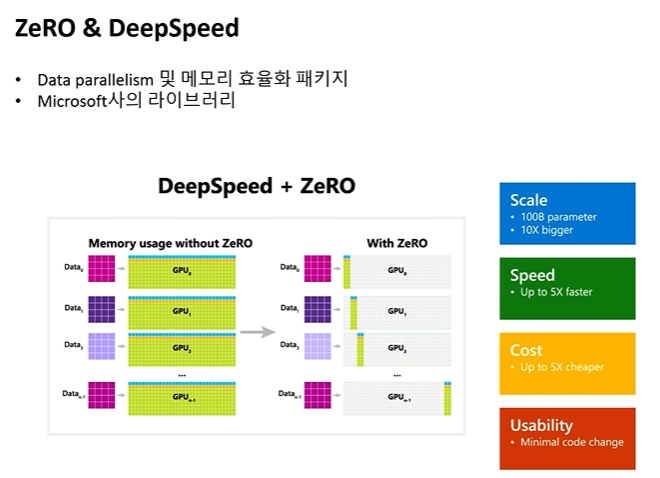

zero와 deepspeed는 DP와 TP, 메모리 효율화 패키지를 전부 다 사용

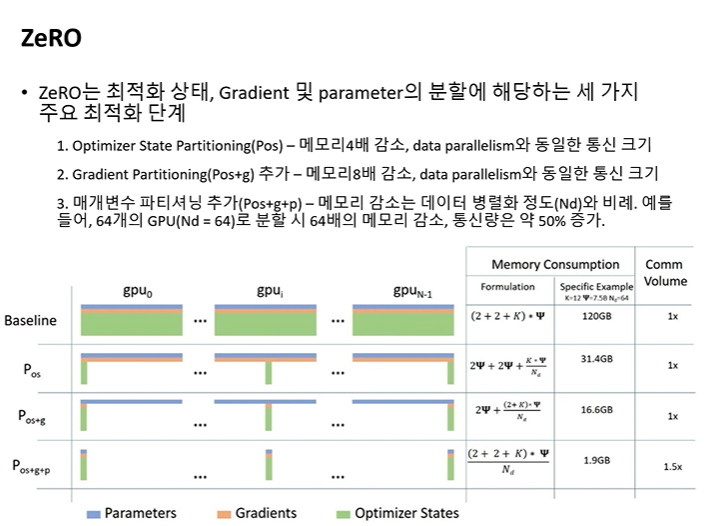

총 3단계가 존재하고 데이터 페럴리즘은 3개 전부 적용이 됨

- 단계가 올라갈수록 메모리 절약이 좋아짐

- 이전에는 데이터 그래디언트 파라미터가 전부 솔려있었지만 단계가 올라갈수록 점점 나눠가짐

독립적으로 다 적용이됨

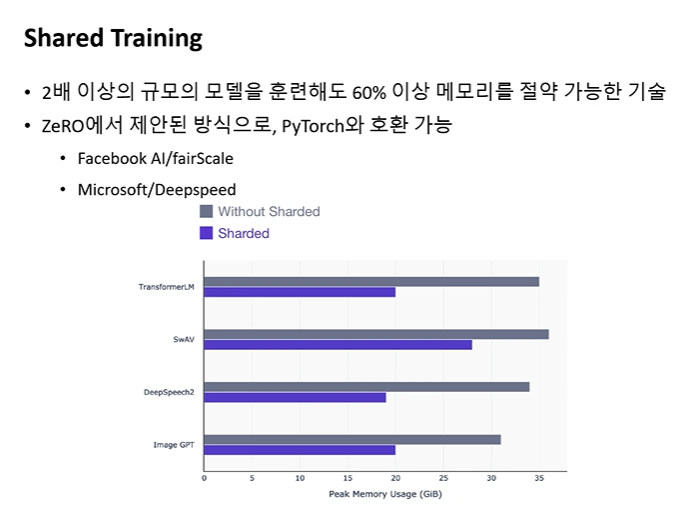

2배 이상의 규모 모델을 훈련해도 60퍼 이상의 메모리가 절야고딤

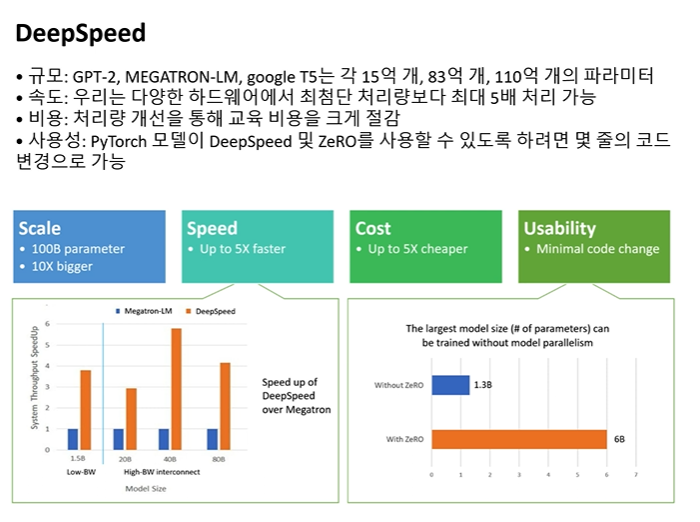

충

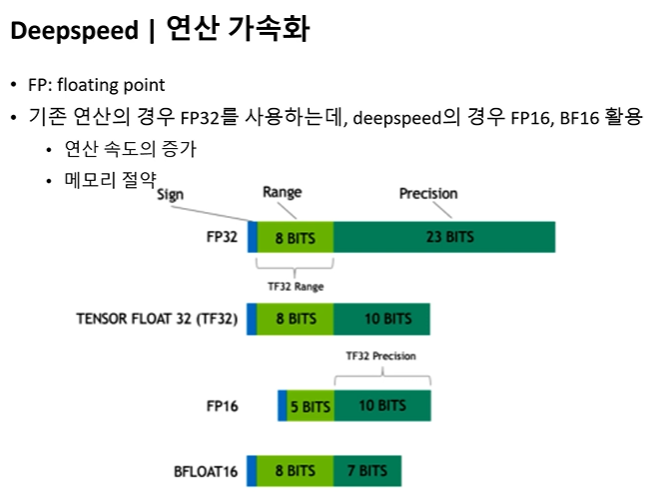

딥스피드는 연산 가속화를 제공

- 양자화를 진행함